In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import feature_functions as ff
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)


In [93]:
ETF_NAME = './hist_data/stocks/SOXL.txt'

df = pd.read_csv(ETF_NAME, sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))

df.head()

test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))



In [94]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [102]:
fig = make_subplots(rows=2, cols=1)
print(df[100:].Close)

fig.add_trace(go.Scatter(x=df[test_split_idx:].Date, y=df[test_split_idx:].Close, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

100      1.861333
101      1.784667
102      1.724000
103      1.670667
104      1.536000
          ...    
2422    21.000000
2423    20.549999
2424    18.790001
2425    17.760000
2426    16.030001
Name: Close, Length: 2327, dtype: float64


In [ ]:
df['close_close_change'] = df['Open'].pct_change()
df['close_close_change'] = df['close_close_change'].shift(-2)
df['target'] = np.where(df['close_close_change'] > 0.0, 1, 0)
df.drop(['close_close_change'], axis=1, inplace=True)
print(df['target'].head())
df[-3:]

In [56]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [57]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)
df['RSI_5'] = relative_strength_idx(df, 5).fillna(0)
df['RSI_21'] = relative_strength_idx(df, 21).fillna(0)
df['RSI_55'] = relative_strength_idx(df, 55).fillna(0)
df['RSI_89'] = relative_strength_idx(df, 89).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [58]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

EMA_12 = pd.Series(df['Close'].ewm(span=34, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=89, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_slow_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [59]:
orig_cols = ['Open','High','Low','Close','Adj Close','Volume']
df = ff.apply_slope_features(df, orig_cols, ff.fib_intervals)

In [60]:
df = df.iloc[89:] # Because of moving averages and MACD line
df = df[:-2]      # Because of shifting close price

df.index = range(len(df))

In [61]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.target, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.target, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.target,  name='Test'))
fig.show()

In [62]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, axis=1)
valid_df = valid_df.drop(drop_cols, axis=1)
test_df  = test_df.drop(drop_cols, axis=1)

In [63]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target'], axis=1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target'], axis=1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 70 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1550 non-null   int64  
 1   Close               1550 non-null   float64
 2   Adj Close           1550 non-null   float64
 3   EMA_9               1550 non-null   float64
 4   SMA_5               1550 non-null   float64
 5   SMA_10              1550 non-null   float64
 6   SMA_15              1550 non-null   float64
 7   SMA_30              1550 non-null   float64
 8   RSI                 1550 non-null   float64
 9   RSI_5               1550 non-null   float64
 10  RSI_21              1550 non-null   float64
 11  RSI_55              1550 non-null   float64
 12  RSI_89              1550 non-null   float64
 13  MACD                1550 non-null   float64
 14  MACD_signal         1550 non-null   float64
 15  MACD_slow_signal    1550 non-null   float64
 16  Open_a

In [64]:
%%time
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
'''
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
best_params = clf.best_params_
'''

CPU times: total: 0 ns
Wall time: 6.97 ms


"\nmodel = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False, scale_pos_weight=ratio)\nclf = GridSearchCV(model, parameters)\n\nclf.fit(X_train, y_train)\n\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\nbest_params = clf.best_params_\n"

In [83]:
%%time

best_params = {'gamma': 0.02, 'learning_rate': 0.0001, 'max_depth': 42, 'n_estimators': 21, 'random_state': 42}
# Set scale_pos_weight in the model
model = xgb.XGBClassifier(**best_params, objective='binary:logistic', scale_pos_weight=ratio)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


CPU times: total: 11.8 s
Wall time: 684 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.02, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=42, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=21, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

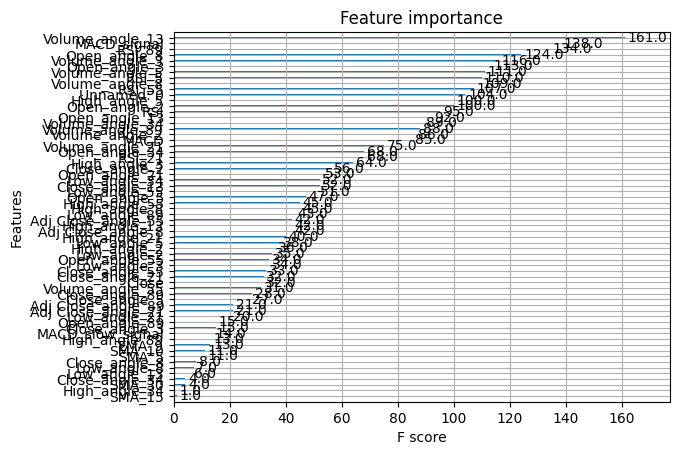

In [84]:
plot_importance(model);

In [85]:
model.save_model("model.bin")

c:\Users\nick5\miniconda3\envs\tree-env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[03:34:37] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



In [86]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [1 0 0 0 1]
y_pred = [0 1 1 0 1]


In [87]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Create a scatter plot for the actual prices (test data only)
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Close, name='Truth', marker_color='LightSkyBlue')])

# Add markers for buy and sell signals (test data only)
buy_indices = test_data[test_data['Predictions'] == 1].index
sell_indices = test_data[test_data['Predictions'] == 0].index

fig.add_trace(go.Scatter(x=test_data.Date.loc[buy_indices],
                         y=test_data.Close.loc[buy_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-up', size=10, color='green'),
                         name='Buy'))

fig.add_trace(go.Scatter(x=test_data.Date.loc[sell_indices],
                         y=test_data.Close.loc[sell_indices],
                         mode='markers',
                         marker=dict(symbol='triangle-down', size=10, color='red'),
                         name='Sell'))

fig.show()

In [88]:
# Filter data for the test period
test_data = df.loc[test_split_idx+1:].copy()
test_data['Predictions'] = y_pred  # Store predictions in a new column

# Calculate daily returns
test_data['Returns'] = test_data['Close'].pct_change()

# Shift returns by one day to align with signal execution
test_data['Strategy_Returns'] = test_data['Predictions'].shift(2) * test_data['Returns']

# Calculate cumulative returns
test_data['Cumulative_Returns'] = (1 + test_data['Strategy_Returns']).cumprod()

# Calculate profitability
profitability = test_data['Cumulative_Returns'].iloc[-1] - 1

print(f"Profitability: {profitability:.2%}")

# Plot cumulative returns
fig = go.Figure(data=[go.Scatter(x=test_data.Date, y=test_data.Cumulative_Returns, name='Cumulative Returns')])
fig.show()

Profitability: -46.81%


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.5196374622356495
Precision: 0.5436893203883495
Recall: 0.632768361581921
F1-score: 0.5848563968668407
